In [1]:
%load_ext nb_black
import os
import sys
import warnings

# add pathway to config files
sys.path.append("../")

import joblib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# import MAGICC tools
import scmdata
import scmdata.database

# import MESMER tools
from mesmer.io import load_cmipng, load_mesmer_output, load_regs_ls_wgt_lon_lat
from mesmer.utils import convert_dict_to_arr, extract_land

# load in configurations used in this script
import configs.config_across_scen_T_cmip6ng_sspall_default as cfg

<IPython.core.display.Javascript object>

/net/cfc/landclim1/beuschl/conda/envs/mesmer-openscmrunner-test/lib/python3.9/site-packages/scmdata/database.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

# Load in all the necessary data

In [2]:
esms_sel = ["CanESM5", "CNRM-CM6-1"]
scenarios_sel = ["h-ssp370", "h-ssp119"]
time = np.arange(1850, 2101)

<IPython.core.display.Javascript object>

In [3]:
print("Load in the MAGICC output of the selected CMIP6 ESMs")

esms_str = ["canesm5-r1i1p1f1", "cnrm-cm6-1-r1i1p1f2"]
scenarios_to_run = ["ssp*"]

magicc_file = {}
for esm, esm_str in zip(esms_sel, esms_str):
    magicc_file[esm] = os.path.join(
        cfg.dir_magicc_esmspecific_emus,
        "rcmip-phase-1_magicc7.1.0.beta-"
        + esm_str
        + "_world_surface-air-temperature-change.csv",
    )

magicc_gsat_output = {}
for esm in esms_sel:
    magicc_gsat_output[esm] = scmdata.ScmRun(magicc_file[esm]).filter(
        scenario=scenarios_to_run
    )

gt_T = {}
for esm in esms_sel:
    gt_T[esm] = {}
    for scen in scenarios_sel:
        # cut out 1850-2100 for the scenario at hand
        gt_T[esm][scen] = (
            magicc_gsat_output[esm].filter(scenario=scen[2:], year=time).values
        )
        # rebaseline to 1850-1900
        gt_T[esm][scen] = gt_T[esm][scen] - np.mean(gt_T[esm][scen][:, :51], axis=1)

Load in the MAGICC output of the selected CMIP6 ESMs


<IPython.core.display.Javascript object>

In [4]:
print("Load in the necessary MESMER output for the selected CMIP6 ESMs")

params_lt = {}
emus_lv = {}
emus_gv = {}
for esm in esms_sel:
    print("start loading", esm)
    params_lt[esm] = load_mesmer_output("params_lt", cfg, esm_str=esm)
    emus_lv[esm] = load_mesmer_output("emus_lv", cfg, esm_str=esm)
    emus_gv[esm] = load_mesmer_output("emus_gv", cfg, esm_str=esm)
nr_esms = len(esms_sel)
nr_emus_lv, nr_ts, nr_gps = emus_lv[esm]["all"]["tas"].shape

Load in the necessary MESMER output for the selected CMIP6 ESMs
start loading CanESM5
start loading CNRM-CM6-1


<IPython.core.display.Javascript object>

In [5]:
print("Load in the runs of the selected CMIP6 ESMs")

# specify the target variable
targ = cfg.targs[0]
print(targ)

# specify all possible scenarios
scenarios = cfg.scenarios


# load in tas with global coverage
tas_g_dict = {}  # tas with global coverage
GSAT_dict = {}  # global mean tas
tas_g = {}
GSAT = {}
time = {}

for esm in esms_sel:
    print(esm)
    tas_g_dict[esm] = {}
    GSAT_dict[esm] = {}
    time[esm] = {}

    for scen in scenarios:

        tas_g_tmp, GSAT_tmp, lon_tmp, lat_tmp, time_tmp = load_cmipng(
            targ, esm, scen, cfg
        )

        if tas_g_tmp is None:
            warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")
        else:  # if scen exists: save fields
            tas_g_dict[esm][scen], GSAT_dict[esm][scen], lon, lat, time[esm][scen] = (
                tas_g_tmp,
                GSAT_tmp,
                lon_tmp,
                lat_tmp,
                time_tmp,
            )

    tas_g[esm] = convert_dict_to_arr(tas_g_dict[esm])
    GSAT[esm] = convert_dict_to_arr(GSAT_dict[esm])

# load in the constant files
reg_dict, ls, wgt_g, lon, lat = load_regs_ls_wgt_lon_lat(cfg.reg_type, lon, lat)

# extract land
tas, reg_dict, ls = extract_land(
    tas_g, reg_dict, wgt_g, ls, threshold_land=cfg.threshold_land
)

Load in the runs of the selected CMIP6 ESMs
tas
CanESM5
CNRM-CM6-1


/tmp/ipykernel_63551/4173118694.py:31: UserWarning: Scenario h-ssp460 does not exist for tas for ESM CNRM-CM6-1
  warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")
/tmp/ipykernel_63551/4173118694.py:31: UserWarning: Scenario h-ssp534-over does not exist for tas for ESM CNRM-CM6-1
  warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")
/tmp/ipykernel_63551/4173118694.py:31: UserWarning: Scenario h-ssp434 does not exist for tas for ESM CNRM-CM6-1
  warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")
/tmp/ipykernel_63551/4173118694.py:31: UserWarning: Scenario h-ssp119 does not exist for tas for ESM CNRM-CM6-1
  warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")


<IPython.core.display.Javascript object>

# Create the ESM-specific emulations

In [6]:
print("Compute global and local ESM-specific emulations")
emus = {}
emus_g = {}
for esm in esms_sel:
    print("start with", esm)
    emus[esm] = {}
    emus_g[esm] = {}
    for scen in scenarios_sel:
        print("start with scenario", scen)
        emus[esm][scen] = np.zeros([nr_emus_lv, nr_ts, nr_gps])
        for gp in np.arange(nr_gps):
            emus[esm][scen][:, :, gp] = (
                params_lt[esm]["coef_gttas"]["tas"][gp] * gt_T[esm][scen]
                + params_lt[esm]["intercept"]["tas"][gp]
                + emus_lv[esm]["all"]["tas"][:, :, gp]
            )
        emus_g[esm][scen] = gt_T[esm][scen] + emus_gv[esm]["all"]

Compute global and local ESM-specific emulations
start with CanESM5
start with scenario h-ssp370
start with scenario h-ssp119
start with CNRM-CM6-1
start with scenario h-ssp370
start with scenario h-ssp119


<IPython.core.display.Javascript object>

# Create regional averages

In [7]:
reg_esms={}
reg_esms['global']={}
reg_emus={}
reg_emus['global']={}


for scen in scenarios_sel:
    reg_esms['global'][scen]={}
    reg_emus['global'][scen]={}

    for esm in esms_sel:
        if scen in GSAT[esm].keys():
            reg_esms['global'][scen][esm]=GSAT[esm][scen]
        # emus - as opposed to ESM runs - exist for each scen
        reg_emus['global'][scen][esm]=emus_g[esm][scen]


regs = ['global_land','ENA','ENA_gp']
for reg in regs:
    reg_esms[reg]={}
    reg_emus[reg]={}
    
    if reg == 'global_land':
        wgt_gps_l = np.sum(reg_dict['wgt_gps_l'],axis=0)
    elif reg == 'ENA_gp':
        wgt_gps_l = np.zeros(reg_dict['wgt_gps_l'].shape[1])
        idx_ENA_gp = 1317
        wgt_gps_l[idx_ENA_gp]=1
    else:
        idx_reg=reg_dict['abbrevs'].index(reg)
        wgt_gps_l=reg_dict['wgt_gps_l'][idx_reg]
    
    for scen in scenarios_sel:
        reg_esms[reg][scen]={}
        reg_emus[reg][scen]={}

        for esm in esms_sel:
            if scen in tas[esm].keys():
                reg_esms[reg][scen][esm]=np.average(tas[esm][scen],weights=wgt_gps_l,axis=2)         
            # emus - as opposed to ESM runs - exist for each scen
            reg_emus[reg][scen][esm]=np.average(emus[esm][scen],weights=wgt_gps_l,axis=2)         


<IPython.core.display.Javascript object>

# Figure 5

In [8]:
print("Specify colors and names")
col = {}
col["CanESM5"] = {}
col["CanESM5"]["all"] = "#f1a340"
col["CanESM5"]["highlight"] = "#b35806"
col["CanESM5"]["esm"] = "grey"
col["CNRM-CM6-1"] = {}
col["CNRM-CM6-1"]["all"] = "#998ec3"
col["CNRM-CM6-1"]["highlight"] = "#542788"
col["CNRM-CM6-1"]["esm"] = "lightgrey"

reg_names = {}
reg_names["global"] = "Global"
reg_names["global_land"] = "Global Land"
reg_names["ENA"] = "E. North-America"
reg_names["ENA_gp"] = "E. North-America grid point"

Specify colors and names


<IPython.core.display.Javascript object>

In [9]:
def plot_reg_ssp(reg, scen, ytick=False, xtick=True, legend=False):
    time_plt = np.arange(1850, 2101)

    for esm in esms_sel[::-1]:
        for i in np.arange(4, 200, 4):
            plt.plot(
                time_plt, reg_emus[reg][scen][esm][i], color=col[esm]["all"], lw=0.5
            )
        plt.plot(
            time_plt, reg_emus[reg][scen][esm][200], color=col[esm]["highlight"], lw=1
        )

        if esm in reg_esms[reg][scen].keys():
            plt.plot(time_plt, reg_esms[reg][scen][esm][0], color=col[esm]["esm"], lw=1)
            plt.plot(time_plt, reg_esms[reg][scen][esm][1], color=col[esm]["esm"], lw=1)

    plt.xlim([2015, 2100])
    plt.xticks(np.arange(2030, 2101, 30))
    plt.ylim([-0.4, 9])

    if ytick is False:
        plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    else:
        if scen == "h-ssp370":
            plt.ylabel("SSP3-7.0\n$\Delta$T [°C]")
        elif scen == "h-ssp119":
            plt.ylabel("SSP1-1.9\n$\Delta$T [°C]")
        else:
            plt.ylabel(scen + "\n$\Delta$T [°C]")

    if xtick is False:
        plt.title(reg_names[reg])
        plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    else:
        plt.xlabel("Year [-]")

<IPython.core.display.Javascript object>

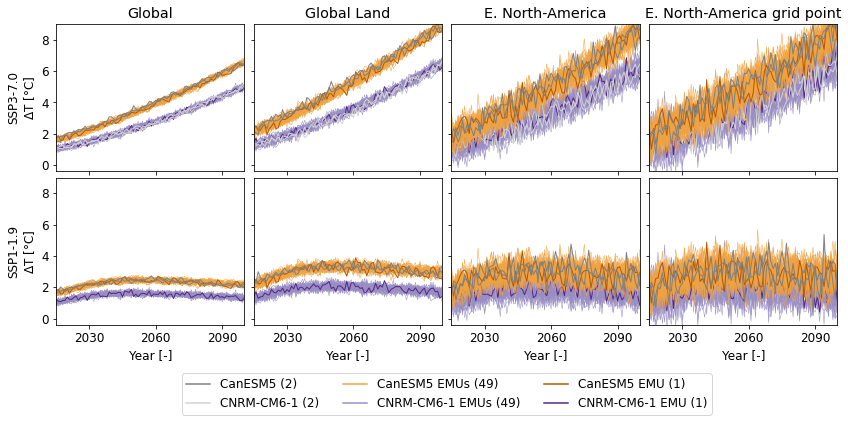

<IPython.core.display.Javascript object>

In [10]:
fig=plt.figure(figsize=(14, 7.3))
plt.rcParams.update({'font.size': 12})

grid = plt.GridSpec(2*8+5, 4, wspace=0.05, hspace=0.5) # create a grid for the subplots

regs = ['global','global_land','ENA','ENA_gp']

for j,scen in enumerate(scenarios_sel): 
    if j == 0:
        xtick=False
    else:
        xtick=True
    for i,reg in enumerate(regs):
        if i == 0:
            ytick = True
        else:
            ytick = False
        ax1 = plt.subplot(grid[j*8:j*8+8,i])
        plot_reg_ssp(reg,scen,xtick=xtick,ytick=ytick)

        
ax1 = plt.subplot(grid[-1,:])


custom_lines = [Line2D([0], [0], color=col['CanESM5']['esm']),
                Line2D([0], [0], color=col['CNRM-CM6-1']['esm']),
        Line2D([0], [0],color=col['CanESM5']['all']),
                Line2D([0], [0],color=col['CNRM-CM6-1']['all']),
              Line2D([0], [0],color=col['CanESM5']['highlight']),
                  Line2D([0], [0],color=col['CNRM-CM6-1']['highlight'])]
plt.legend(custom_lines, ['CanESM5 (2)','CNRM-CM6-1 (2)','CanESM5 EMUs (49)','CNRM-CM6-1 EMUs (49)','CanESM5 EMU (1)','CNRM-CM6-1 EMU (1)'],loc='lower center',ncol=3)
plt.axis('off');


        

#plt.savefig(cfg.dir_plots+'ts_emus_'+"_".join(esms_sel)+'_g_gl_ENA_ENAgp_'+"_".join(scenarios_sel)+'.png' ,dpi=200 ,bbox_inches='tight')
#plt.savefig(cfg.dir_plots+'ts_emus_'+"_".join(esms_sel)+'_g_gl_ENA_ENAgp_'+"_".join(scenarios_sel)+'.pdf' ,dpi=200 ,bbox_inches='tight')

